# Info

This script fits data using Gaussian functions. 

The fitting is handled by the lmfit package. Use the following command to install lmfit:

pip install lmfit

-----------------------
Created by Jerry LaRue, larue@chapman.edu, 9/2018

Last modified by Jerry LaRue, larue@chapman.edu, 9/2018

# Load data

In [4]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import pylab as plb
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from lmfit import model
from lmfit.models import GaussianModel, LinearModel, VoigtModel

Folder = 'C:/Users/larue/OneDrive - Chapman University/Research/X-Ray Femtochemistry/Fermi 2017/Binned/BT2/'
File_Input = 'XAS_014_020_bin.h5'
File_Output = 'XAS_014_020_bin_fit.h5'

print('Loading data from: ' + File_Input)

##### Check for files #####

Success = True
if os.path.isfile(Folder + File_Input) :
    f = h5py.File(Folder + File_Input, 'r')
else :
    Success = False
    print(File_Input + ' file missing')

if os.path.isfile(Folder + File_Input) :
    
    # General
    if not 'runs' in f :
        Success = False
        print('Run list missing')
    
    # Energy
    if not 'BinnedData/E_bin_centers' in f :
        Success = False
        print('Energy values missing')
    
    # Delay
    if not 'BinnedData/delays_fs' in f :
        Success = False
        print('Delay Values missing')
    
    # Spectra
    if not 'BinnedData/XAS_2dmatrix' in f :
        Success = False
        print('Spectral data missing')

if Success :

    ##### Load data #####

    # General
    Runs = f['runs'][...]

    # Energy
    Spectra_Energy = f['BinnedData/E_bin_centers'][...]

    # Delay
    Spectra_Delay = f['BinnedData/delays_fs'][...]

    # Spectra
    Spectra_Values = f['/BinnedData/XAS_2dmatrix'][...]

    f.close()

Loading data from: XAS_014_020_bin.h5


## Fit data

____________________________________________________________________________________________________


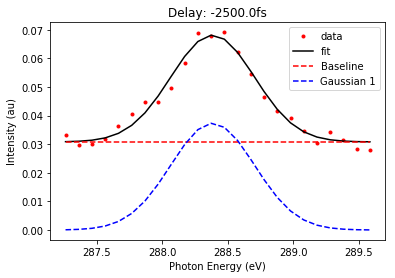

Baseline: 0.0308
Gaussian 1 | Amplitude: 0.0299, Energy: 288.4, Width: 0.319
____________________________________________________________________________________________________


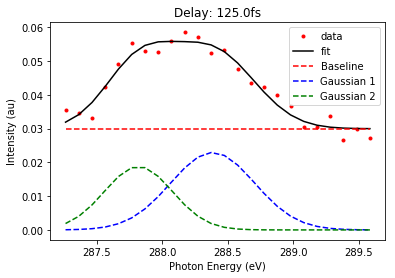

Baseline: 0.0299
Gaussian 1 | Amplitude: 0.0183, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0122, Energy: 287.8, Width: 0.259
____________________________________________________________________________________________________


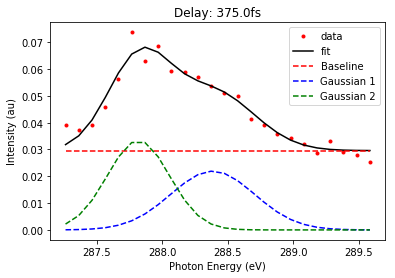

Baseline: 0.0296
Gaussian 1 | Amplitude: 0.0176, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0199, Energy: 287.8, Width: 0.238
____________________________________________________________________________________________________


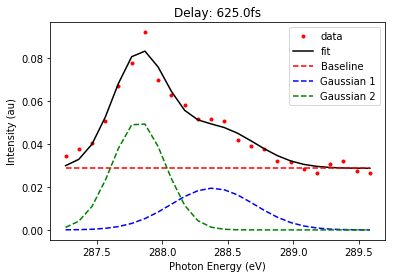

Baseline: 0.0286
Gaussian 1 | Amplitude: 0.0155, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0258, Energy: 287.8, Width: 0.203
____________________________________________________________________________________________________


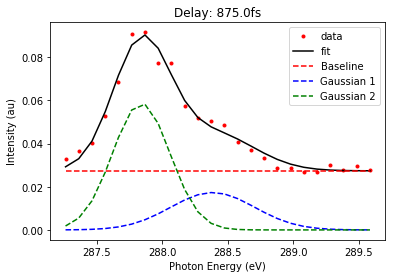

Baseline: 0.0274
Gaussian 1 | Amplitude: 0.0139, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0322, Energy: 287.8, Width: 0.219
____________________________________________________________________________________________________


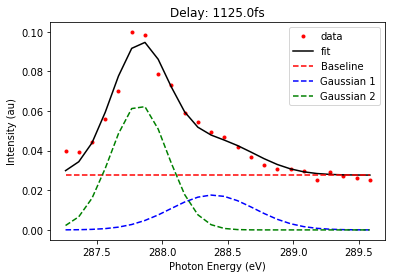

Baseline: 0.0276
Gaussian 1 | Amplitude: 0.0141, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0345, Energy: 287.8, Width: 0.217
____________________________________________________________________________________________________


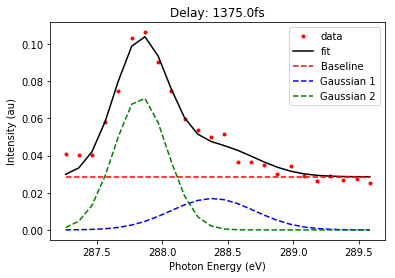

Baseline: 0.0286
Gaussian 1 | Amplitude: 0.0135, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0362, Energy: 287.8, Width: 0.202
____________________________________________________________________________________________________


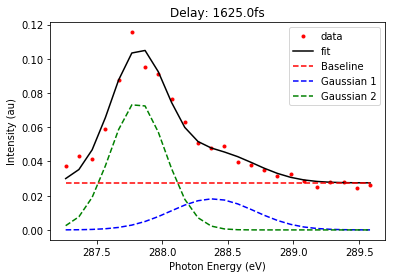

Baseline: 0.0275
Gaussian 1 | Amplitude: 0.0145, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0396, Energy: 287.8, Width: 0.211
____________________________________________________________________________________________________


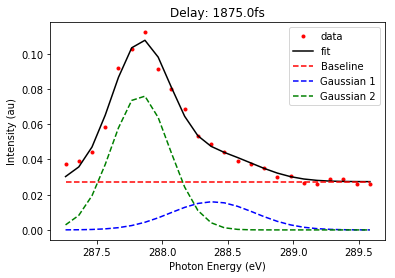

Baseline: 0.0274
Gaussian 1 | Amplitude: 0.0128, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0428, Energy: 287.8, Width: 0.222
____________________________________________________________________________________________________


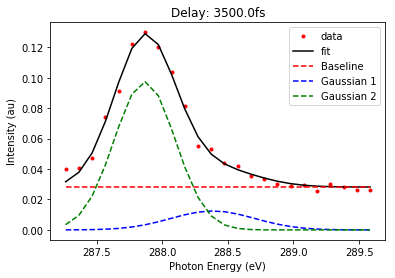

Baseline: 0.0282
Gaussian 1 | Amplitude: 0.01, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0569, Energy: 287.9, Width: 0.233
____________________________________________________________________________________________________


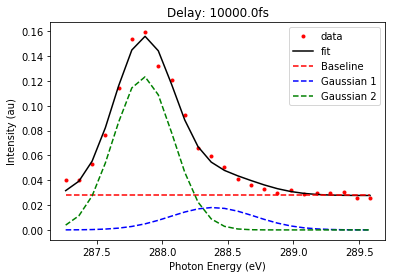

Baseline: 0.0277
Gaussian 1 | Amplitude: 0.0144, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0697, Energy: 287.9, Width: 0.225
____________________________________________________________________________________________________


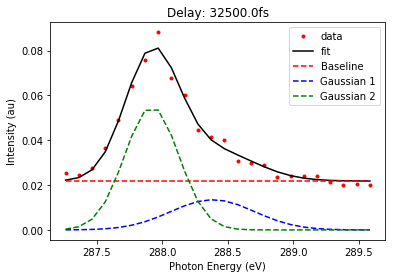

Baseline: 0.0218
Gaussian 1 | Amplitude: 0.0108, Energy: 288.4, Width: 0.319
Gaussian 2 | Amplitude: 0.0284, Energy: 287.9, Width: 0.206
____________________________________________________________________________________________________


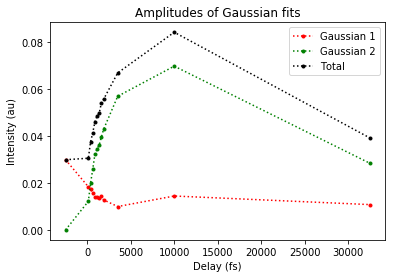

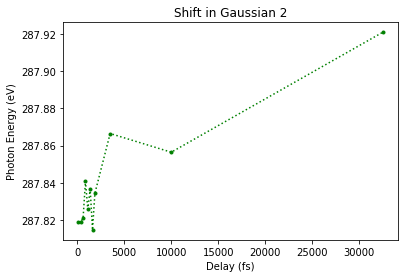

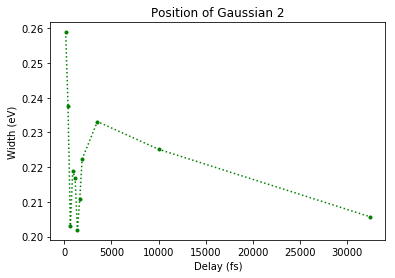

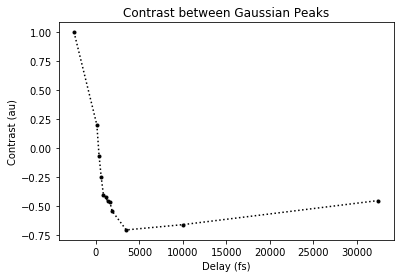

In [8]:
##### Fit data #####

# The peak position and width of the reference data are fixed for fitting after the initial fit.
# A second Gaussian peak is used to fit changes in data from the reference data.
# In the past, I have used multiple peaks, however 1 for reference and 1 for data work well here.

###### Setup arrays #####

Gaussian1_Amplitude = list()
Gaussian1_Center = list()
Gaussian1_Sigma = list()
Gaussian2_Amplitude = list()
Gaussian2_Center = list()
Gaussian2_Sigma = list()

###### Trim data #####

Fit_ROI_Min = 287.3
Fit_ROI_Max = 290

X_Index_Min = (np.abs(Spectra_Energy - Fit_ROI_Min)).argmin()
X_Index_Max = (np.abs(Spectra_Energy - Fit_ROI_Max)).argmin()
Spectra_Values = np.transpose(Spectra_Values)
Spectra_Values = Spectra_Values[X_Index_Min:X_Index_Max]
Spectra_Values = np.transpose(Spectra_Values)
Spectra_Energy = Spectra_Energy[X_Index_Min:X_Index_Max]

##### Fit reference data #####

# The first delay in the data matrix is used as reference (assumes negative delay)
    
# Find fits
remove = np.argwhere(np.isnan(Spectra_Values[0]))
x = np.delete(Spectra_Energy,remove)
y = np.delete(Spectra_Values[0],remove)
n = len(x)

peaks = GaussianModel(prefix='G1_')
background = LinearModel(prefix='B_')
model = peaks + background

params = model.make_params(B_slope=0, B_intercept=0.05, 
                           G1_center=288.409422, G1_sigma=0.29755441, G1_amplitude=0.050,
                           G2_center=287.8, G2_sigma=0.3, G2_amplitude=0.050)

params['B_slope'].vary = False

ref = model.fit(y, params, x=x)

comps = ref.eval_components(ref.params, x=x)

# Plot data and fits
print('____________________________________________________________________________________________________')

plt.plot(x, y,'r.', label='data')
plt.plot(x, ref.best_fit, 'k-', label='fit')
plt.plot(x, comps['B_'], 'r--', label='Baseline')
plt.plot(x, comps['G1_'], 'b--', label='Gaussian 1')
plt.legend(), plt.xlabel('Photon Energy (eV)'), plt.ylabel('Intensity (au)')
plt.title('Delay: ' + str(Spectra_Delay[0]) + 'fs')
plt.show()

print('Baseline: '+str(round(ref.params['B_intercept'].value,4)))
print('Gaussian 1 | Amplitude: ' + str(round(ref.params['G1_amplitude'].value,4)) + ', Energy: ' + str(round(ref.params['G1_center'].value,1)) + ', Width: ' + str(round(ref.params['G1_sigma'].value,3)))

Gaussian1_Amplitude.append(ref.params['G1_amplitude'].value)
Gaussian1_Center.append(ref.params['G1_center'].value)
Gaussian1_Sigma.append(ref.params['G1_sigma'].value)
Gaussian2_Amplitude.append(0)
Gaussian2_Center.append(np.nan)
Gaussian2_Sigma.append(np.nan)

##### Fit data with reference #####

i = 1
while i < len(Spectra_Delay) :
    
    # Find fits
    remove = np.argwhere(np.isnan(Spectra_Values[i]))
    x = np.delete(Spectra_Energy,remove)
    y = np.delete(Spectra_Values[i],remove)
    n = len(x)
    
    peaks = GaussianModel(prefix='G1_') + GaussianModel(prefix='G2_')
    background = LinearModel(prefix='B_')
    model = peaks + background

    params = model.make_params(B_slope=0, B_intercept=0.05,
                               G1_amplitude=0.050, G1_center=ref.params['G1_center'].value, G1_sigma=ref.params['G1_sigma'].value,
                               G2_amplitude=0.050, G2_center=287.8, G2_sigma=0.3)
    
    params['G1_amplitude'].min= 0
    params['G2_center'].min = 287.5
    params['G2_center'].max = 290
    params['G2_amplitude'].min= 0
    params['G2_sigma'].max = 1
    params['G2_sigma'].min = 0.2
    
    params['B_slope'].vary = False
    params['G1_center'].vary = False
    params['G1_sigma'].vary = False
    
    result = model.fit(y, params, x=x)
    
    comps = result.eval_components(result.params, x=x)
    #print(result.fit_report())
    
    ##### Plot data and fits #####
    print('____________________________________________________________________________________________________')
    
    plt.plot(x, y,'r.', label='data')
    plt.plot(x, result.best_fit, 'k-', label='fit')
    plt.plot(x, comps['B_'], 'r--', label='Baseline')
    plt.plot(x, comps['G1_'], 'b--', label='Gaussian 1')
    plt.plot(x, comps['G2_'], 'g--', label='Gaussian 2')
    plt.legend(), plt.xlabel('Photon Energy (eV)'), plt.ylabel('Intensity (au)')
    plt.title('Delay: ' + str(Spectra_Delay[i]) + 'fs')
    plt.show()
    
    print('Baseline: '+str(round(result.params['B_intercept'].value,4)))
    print('Gaussian 1 | Amplitude: ' + str(round(result.params['G1_amplitude'].value,4)) + ', Energy: ' + str(round(result.params['G1_center'].value,1)) + ', Width: ' + str(round(result.params['G1_sigma'].value,3)))
    print('Gaussian 2 | Amplitude: ' + str(round(result.params['G2_amplitude'].value,4)) + ', Energy: ' + str(round(result.params['G2_center'].value,1)) + ', Width: ' + str(round(result.params['G2_sigma'].value,3)))
    
    Gaussian1_Amplitude.append(result.params['G1_amplitude'].value)
    Gaussian1_Center.append(result.params['G1_center'].value)
    Gaussian1_Sigma.append(result.params['G1_sigma'].value)
    Gaussian2_Amplitude.append(result.params['G2_amplitude'].value)
    Gaussian2_Center.append(result.params['G2_center'].value)
    Gaussian2_Sigma.append(result.params['G2_sigma'].value)
    
    i += 1

Gaussian1_Amplitude = np.array(Gaussian1_Amplitude)
Gaussian1_Center = np.array(Gaussian1_Center)
Gaussian1_Sigma = np.array(Gaussian1_Sigma)
Gaussian2_Amplitude = np.array(Gaussian2_Amplitude)
Gaussian2_Center = np.array(Gaussian2_Center)
Gaussian2_Sigma = np.array(Gaussian2_Sigma)
Total_Amplitude = Gaussian1_Amplitude + Gaussian2_Amplitude
Contrast = (Gaussian1_Amplitude-Gaussian2_Amplitude)/(Gaussian1_Amplitude+Gaussian2_Amplitude)

##### Plot trends #####
print('____________________________________________________________________________________________________')

plt.plot(Spectra_Delay, Gaussian1_Amplitude,'r.:', label='Gaussian 1')
plt.plot(Spectra_Delay, Gaussian2_Amplitude,'g.:', label='Gaussian 2')
plt.plot(Spectra_Delay, Total_Amplitude,'k.:', label='Total')
plt.legend(), plt.xlabel('Delay (fs)'), plt.ylabel('Intensity (au)')
plt.title('Amplitudes of Gaussian fits')
plt.show()

plt.plot(Spectra_Delay[1:], Gaussian2_Center[1:],'g.:', label='Gaussian 2')
plt.xlabel('Delay (fs)'), plt.ylabel('Photon Energy (eV)')
plt.title('Shift in Gaussian 2')
plt.show()

plt.plot(Spectra_Delay[1:], Gaussian2_Sigma[1:],'g.:', label='Gaussian 2')
plt.xlabel('Delay (fs)'), plt.ylabel('Width (eV)')
plt.title('Position of Gaussian 2')
plt.show()

plt.plot(Spectra_Delay, Contrast,'k.:', label='Gaussian 2')
plt.xlabel('Delay (fs)'), plt.ylabel('Contrast (au)')
plt.title('Contrast between Gaussian Peaks')
plt.show()